### 39. Methodenseminar
## Big Data Module II: Introduction to Social Network Science with Python
# 3.2 Scale-Free Networks (Exercise)
**Author**: <a href='https://www.gesis.org/person/haiko.lietz'>Haiko Lietz</a>, GESIS - Leibniz Institute for the Social Sciences

**Date**: 17 July 2019

**Library versions**: ``networkx`` 2.2 ([documentation](https://networkx.github.io/documentation/))

***

## Exercise 1
In the demo, in section 3.2.4.1, we found preferential attachment to be linear for how citations in 2007-2009 predict citations in 1020-2012.
#### How does preferential attachment evolve over time?
In other words, does the Matthew Effect increase over time? Compare these cultural dynamics to the emergence of the Small-World social (co-authorship) network.

In [1]:
import pandas as pd
import numpy as np

In [2]:
citations = pd.read_csv('../data/sns/citations.txt', header='infer', delimiter='\t', encoding='utf-8')
references = pd.read_csv('../data/sns/references.txt', header='infer', delimiter='\t', encoding='utf-8')
cited_references = pd.merge(left=citations, right=references, on='reference_id')
publications = pd.read_csv('../data/sns/publications.txt', header='infer', delimiter='\t', encoding='utf-8')
publications['time'] = (3*np.floor(publications['time']/3)+2).astype('int')
cited_references_time = pd.merge(left=cited_references, right=publications[['publication_id', 'time']], on='publication_id')
cited_references_time = cited_references_time.groupby(['time', 'reference']).size().reset_index(name='citations')
cited_references_time.head()

,time,reference,citations
0,1925,BENTHAM_1869_COMMUNICATION,1
1,1925,FISHER_1922_J_87,1
2,1925,FISHER_1992_P_309,1
3,1925,HOLMES_1913_AGE,1
4,1928,FOCK_1924_M_161,1


In [3]:
years = list(cited_references_time['time'].drop_duplicates())

In [4]:
def ols_reg(a):
    # log and reshape data
    x_log10 = np.log10(a[:, 0])
    x_log10_reshape = x_log10.reshape(len(x_log10), 1)
    y_log10 = np.log10(a[:, 1])
    y_log10_reshape = y_log10.reshape(len(y_log10), 1)
    # fit linear model in log space
    import sklearn.linear_model as sk_lm
    reg = sk_lm.LinearRegression()
    reg.fit(x_log10_reshape, y_log10_reshape)
    y_log10_reshape_predict = reg.predict(x_log10_reshape)
    # create output
    x_min = min(a[:, 0])
    x_max = max(a[:, 0])
    d = 10**reg.intercept_[0]
    beta = reg.coef_[0][0]
    from sklearn.metrics import r2_score
    r2 = r2_score(y_log10_reshape, y_log10_reshape_predict)
    a_fit = np.array([[x_min, d*x_min**beta], [x_max, d*x_max**beta]])
    return beta, r2, a_fit

In [5]:
len(years)

28

In [6]:
betas = []
for t in range(11, len(years)):
    cited_references_t_0 = cited_references_time[cited_references_time['time'] == years[t-1]]
    cited_references_t = cited_references_time[cited_references_time['time'] == years[t]]
    preferential_attachment = pd.merge(left=cited_references_t_0, right=cited_references_t, on='reference')
    preferential_attachment.columns = ['time_0', 'reference', 'citations_0', 'time', 'citations']
    preferential_attachment = preferential_attachment[['time_0', 'time', 'reference', 'citations_0', 'citations']]
    a = np.column_stack((preferential_attachment['citations_0'], preferential_attachment['citations']))
    beta, r2, a_fit = ols_reg(a)
    betas.append(beta)

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

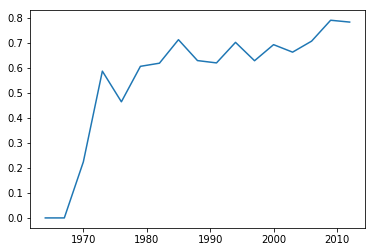

In [8]:
plt.plot(years[11:], betas)

#### Emergence of the co-authorship Small World for time slices
<img src='images/social_emergence.png'>

#### Emergence of the co-authorship Small World for cumulative time increases
<img src='images/social_emergence_cum.png'>

## Exercise 2
Four distributions can be extracted from the BTW13 dataset of political tweets:
- number of followee selections
- number of hashtag selections
- number of mentionee selections
- number of retweetee selections

#### What functions best fit these distributions? How plausible are power law fits?
Be careful with setting lower cutoffs ``xmin`` because they don't make sense if the best fit is not a power law. Plot the distribution first to decide what ``xmin`` to set. When comparing functions, disregard the ``lognormal`` (not the ``lognormal_positive``) as the lognormal can have a negative mean. Think about possible underlying mechanisms and what the patterns mean for the Twitter users.

In [9]:
import powerlaw as pl

In [10]:
def plot_pdf(l):
    fit = pl.Fit(l, discrete=True, xmin=1)
    fit.plot_pdf(marker='o', ls='', linear_bins=True)
    fit.plot_pdf(marker='o', ls='', linear_bins=False)

In [11]:
def fit_power_law(l, xmin=None):
    fit = pl.Fit(l, discrete=True, xmin=xmin)
    fit.plot_pdf(marker='o', ls='', linear_bins=True)
    fit.plot_pdf(marker='o', ls='')
    #fit.exponential.plot_pdf(label='Exponential')
    fit.stretched_exponential.plot_pdf(label='Stretched Exponential')
    fit.lognormal_positive.plot_pdf(label='Lognormal')
    fit.power_law.plot_pdf(label='Power Law')
    fit.truncated_power_law.plot_pdf(label='Truncated Power Law')
    plt.legend()
    return fit

In [12]:
def compare_functions(f):
    function = ['exponential', 'stretched_exponential', 'lognormal', 'lognormal_positive', 'power_law', 'truncated_power_law']
    from numpy import zeros
    f_compare_R = zeros((6, 6), dtype=float)
    f_compare_p_R = zeros((6, 6), dtype=float)
    for i in range(0, 6):
        for j in range(0, 6):
            R, p_R = f.distribution_compare(function[i], function[j])
            f_compare_R[i, j] = R
            f_compare_p_R[i, j] = p_R
    from pandas import DataFrame
    return DataFrame(f_compare_R, index=function, columns=function), DataFrame(f_compare_p_R, index=function, columns=function)

In [13]:
def p_value(f, sims=2500):
    prob = f.n_tail/len(f.data_original)
    body = [x for x in f.data_original if x < f.xmin]
    l = []
    from random import random, sample
    from powerlaw import Fit, Power_Law
    for i in range(0, sims):
        x = []
        for j in range(0, len(f.data_original)):
            if random() <= prob:
                x.append(int(Power_Law(discrete=True, xmin=f.xmin, parameters=[f.power_law.alpha]).generate_random(1)))
            else:
                x.append(sample(body, 1)[0])
        x_fit = Fit(x, discrete=True).power_law
        l.append(x_fit.KS() > f.power_law.KS())
    p = sum(l)/sims
    return p

#### Following

In [14]:
follow = pd.read_csv('../data/btw13/follow.txt', header='infer', delimiter='\t', encoding='utf-8')
follow.head()

,user_id_follower,user_id_followee
0,0,3
1,0,17
2,0,20
3,0,41
4,0,59


In [15]:
number_of_followers = list(follow.groupby('user_id_followee').size())

C:\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


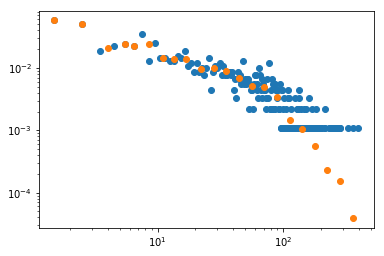

In [16]:
plot_pdf(number_of_followers)

In [17]:
fit_follow = pl.Fit(number_of_followers, discrete=True, xmin=1)

In [18]:
compare_functions(fit_follow)

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


(                       exponential  stretched_exponential   lognormal  \
 exponential               0.000000             -34.124561   27.542496   
 stretched_exponential    34.124561               0.000000   61.667057   
 lognormal               -27.542496             -61.667057    0.000000   
 lognormal_positive      -27.542496             -61.667057    0.000000   
 power_law              -510.209657            -544.334218 -482.667161   
 truncated_power_law    -144.630261            -178.754822 -117.087765   
 
                        lognormal_positive   power_law  truncated_power_law  
 exponential                     27.542496  510.209657           144.630261  
 stretched_exponential           61.667057  544.334218           178.754822  
 lognormal                        0.000000  482.667161           117.087765  
 lognormal_positive               0.000000  482.667161           117.087765  
 power_law                     -482.667161    0.000000          -365.579396  
 truncated_p

In [19]:
p_value(fit_follow, sims=10)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
C:\Anaconda3\lib\site-packages\powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


0.0

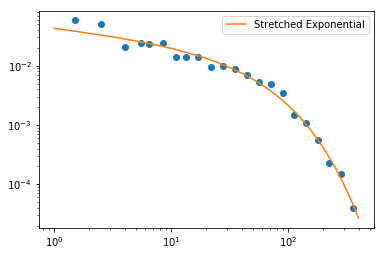

In [20]:
fit_follow.plot_pdf(marker='o', ls='', linear_bins=False)
fit_follow.stretched_exponential.plot_pdf(label='Stretched Exponential')
plt.legend()

No scaling regime (linear behavior on log-log plot) is visible. Therefore ``xmin=1``.

The stretched exponential is always a better fit and the difference can be trusted.

A power law fit is not plausible at all.

#### Tagging

In [21]:
tag = pd.read_csv('../data/btw13/tag.txt', header='infer', delimiter='\t', encoding='utf-8')
tag.head()

,transaction_id,hashtag_id
0,0,13587
1,1,22197
2,2,1231
3,2,15234
4,2,17076


In [22]:
number_of_tags = list(tag.groupby('hashtag_id').size())

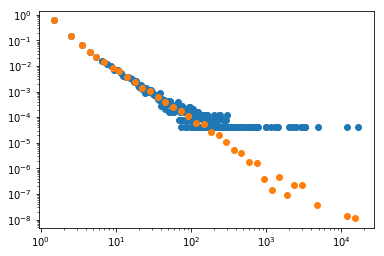

In [23]:
plot_pdf(number_of_tags)

In [24]:
fit_tag = pl.Fit(number_of_tags, discrete=True, xmin=None)

Calculating best minimal value for power law fit


In [25]:
compare_functions(fit_tag)

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


(                       exponential  stretched_exponential    lognormal  \
 exponential               0.000000           -6648.578524 -6669.015453   
 stretched_exponential  6648.578524               0.000000   -20.436929   
 lognormal              6669.015453              20.436929     0.000000   
 lognormal_positive     6509.023098            -139.555425  -159.992354   
 power_law              6663.808380              15.229856    -5.207073   
 truncated_power_law    6668.064838              19.486314    -0.950615   
 
                        lognormal_positive    power_law  truncated_power_law  
 exponential                  -6509.023098 -6663.808380         -6668.064838  
 stretched_exponential          139.555425   -15.229856           -19.486314  
 lognormal                      159.992354     5.207073             0.950615  
 lognormal_positive               0.000000  -154.785282          -159.041740  
 power_law                      154.785282     0.000000            -4.256458  

In [26]:
p_value(fit_tag, sims=10)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


1.0

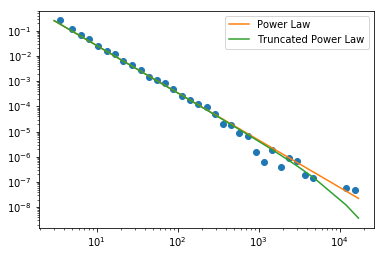

In [27]:
fit_tag.plot_pdf(marker='o', ls='', linear_bins=False)
fit_tag.power_law.plot_pdf(label='Power Law')
fit_tag.truncated_power_law.plot_pdf(label='Truncated Power Law')
plt.legend()

In [28]:
fit_tag.power_law.alpha

1.8785889876034108

In [29]:
fit_tag.truncated_power_law.alpha

1.879819965347695

A scaling regime is visible. Therefore ``xmin=None``.

The truncated power law is the best fit, but a simple power law is highly plausible.

The exponents of the power law and the truncated power law are almost identical, i.e., risk of overfitting is low.

#### Mentioning

In [30]:
mention = pd.read_csv('../data/btw13/mention.txt', header='infer', delimiter='\t', encoding='utf-8')
mention.head()

,transaction_id,user_id_mentioner,user_id_mentionee
0,3,96,756
1,4,413,756
2,9,37,856
3,32,821,748
4,43,426,709


In [31]:
number_of_mentioners = list(mention.groupby('user_id_mentionee').size())

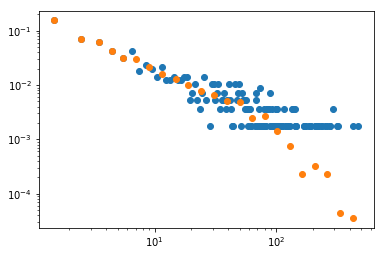

In [32]:
plot_pdf(number_of_mentioners)

In [33]:
fit_mention = pl.Fit(number_of_mentioners, discrete=True, xmin=None)

Calculating best minimal value for power law fit


In [34]:
fit_mention.xmin

67.0

In [35]:
fit_mention = pl.Fit(number_of_mentioners, discrete=True, xmin=1)

In [36]:
compare_functions(fit_mention)

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


(                       exponential  stretched_exponential   lognormal  \
 exponential               0.000000            -159.723481 -142.842761   
 stretched_exponential   159.723481               0.000000   16.880721   
 lognormal               142.842761             -16.880721    0.000000   
 lognormal_positive      142.842761             -16.880721    0.000000   
 power_law                15.642451            -144.081030 -127.200309   
 truncated_power_law     154.961939              -4.761542   12.119179   
 
                        lognormal_positive   power_law  truncated_power_law  
 exponential                   -142.842761  -15.642451          -154.961939  
 stretched_exponential           16.880721  144.081030             4.761542  
 lognormal                        0.000000  127.200309           -12.119179  
 lognormal_positive               0.000000  127.200309           -12.119179  
 power_law                     -127.200309    0.000000          -139.319488  
 truncated_p

In [37]:
p_value(fit_mention, sims=10)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


0.0

In [38]:
fit_mention.truncated_power_law.alpha

1.0000000328297283

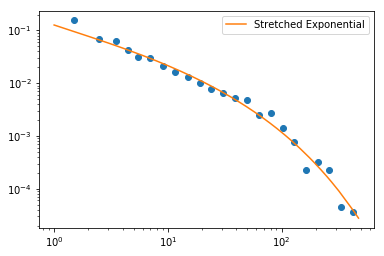

In [39]:
fit_mention.plot_pdf(marker='o', ls='', linear_bins=False)
fit_mention.stretched_exponential.plot_pdf(label='Stretched Exponential')
plt.legend()

There is a possible scaling regime starting at the minimum. But setting ``xmin=None`` causes a lower cutoff of 67 to be estimated, resulting in a "fat tail" that is too small to speak of scaling. Therefore, ``xmin=1``.

A pure power law is highly implausible.

The stretched exponential and truncated power law are equally good fits based on log-likelihood comparison. But the exponent for the truncated power law is too small (``alpha=1``), too small for a social system.

Therefore the stretched exponential is the best fit.

#### Retweeting

In [40]:
retweet = pd.read_csv('../data/btw13/retweet.txt', header='infer', delimiter='\t', encoding='utf-8')
retweet.head()

,transaction_id,user_id_retweeter,user_id_retweetee
0,10,48,20
1,44,712,37
2,57,13,37
3,62,13,37
4,65,13,37


In [41]:
number_of_retweeters = list(retweet.groupby('user_id_retweetee').size())

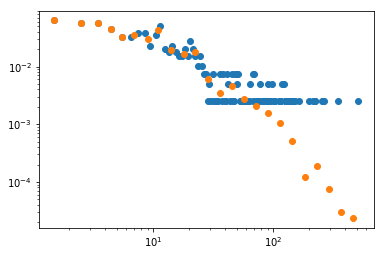

In [42]:
plot_pdf(number_of_retweeters)

In [43]:
fit_retweet = pl.Fit(number_of_retweeters, discrete=True, xmin=1)

In [44]:
compare_functions(fit_retweet)

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


(                       exponential  stretched_exponential   lognormal  \
 exponential               0.000000             -50.057247  -53.680436   
 stretched_exponential    50.057247               0.000000   -3.623189   
 lognormal                53.680436               3.623189    0.000000   
 lognormal_positive       53.680436               3.623189    0.000000   
 power_law              -118.423152            -168.480399 -172.103588   
 truncated_power_law       9.301694             -40.755553  -44.378742   
 
                        lognormal_positive   power_law  truncated_power_law  
 exponential                    -53.680436  118.423152            -9.301694  
 stretched_exponential           -3.623189  168.480399            40.755553  
 lognormal                        0.000000  172.103588            44.378742  
 lognormal_positive               0.000000  172.103588            44.378742  
 power_law                     -172.103588    0.000000          -127.724846  
 truncated_p

In [45]:
p_value(fit_retweet, sims=10)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


0.0

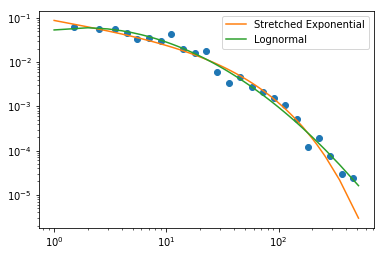

In [46]:
fit_retweet.plot_pdf(marker='o', ls='', linear_bins=False)
fit_retweet.stretched_exponential.plot_pdf(label='Stretched Exponential')
fit_retweet.lognormal_positive.plot_pdf(label='Lognormal')
plt.legend()

No scaling regime is visible. Therefore ``xmin=1``.

The stretched exponential and Lognormal are equally good fits.

A power law fit is not plausible at all.

## Exercise 3
The goal of Network Science is to find patterns that universally appear in complex systems (not only social systems). Ten complex networks, described [here](http://www.networksciencebook.com/translations/en/resources/data.html), are studied by Barabási in his book *Network Science*.
#### What's the evidence for scale-freeness in the networks selected by Barabási?
Can you reproduce the results [here](http://www.networksciencebook.com/chapter/4#advanced-c) (table 4.1)? Networks are ordered by size, so the collaboration network is fastest to assess.

#### Barabási's Datsets
Of these, the citation, email, metabolic, phonecalls, and www are directed.

In [47]:
collaboration = pd.read_csv('../data/networksciencebook/collaboration.edgelist.zip', header='infer', delimiter='\t', encoding='utf-8')
phonecalls = pd.read_csv('../data/networksciencebook/phonecalls.edgelist.zip', header='infer', delimiter='\t', encoding='utf-8')
email = pd.read_csv('../data/networksciencebook/email.edgelist.zip', header='infer', delimiter='\t', encoding='utf-8')
www = pd.read_csv('../data/networksciencebook/www.edgelist.zip', header='infer', delimiter='\t', encoding='utf-8')
citation = pd.read_csv('../data/networksciencebook/citation.edgelist.zip', header='infer', delimiter='\t', encoding='utf-8')
actor = pd.read_csv('../data/networksciencebook/actor.edgelist.zip', header='infer', delimiter='\t', encoding='utf-8')
#internet = pd.read_csv('../data/networksciencebook/internet.edgelist.zip', header='infer', delimiter='\t', encoding='utf-8')
#metabolic = pd.read_csv('../data/networksciencebook/metabolic.edgelist.zip', header='infer', delimiter='\t', encoding='utf-8')
#powergrid = pd.read_csv('../data/networksciencebook/powergrid.edgelist.zip', header='infer', delimiter='\t', encoding='utf-8')
#protein = pd.read_csv('../data/networksciencebook/protein.edgelist.zip', header='infer', delimiter='\t', encoding='utf-8')

In [48]:
def fit_power_law(l, xmin=None):
    fit = pl.Fit(l, discrete=True, xmin=xmin)
    fit.plot_pdf(marker='o', ls='', linear_bins=True)
    fit.plot_pdf(marker='o', ls='')
    #fit.exponential.plot_pdf(label='Exponential')
    fit.stretched_exponential.plot_pdf(label='Stretched Exponential')
    fit.lognormal_positive.plot_pdf(label='Lognormal')
    fit.power_law.plot_pdf(label='Power Law')
    fit.truncated_power_law.plot_pdf(label='Truncated Power Law')
    plt.legend()
    return fit

In [49]:
import networkx as nx

#### The Collaboration Dataset

In [50]:
Co = nx.Graph(name='collaboration')
Co.add_edges_from(collaboration.values)
Co_degree = [degree for (node, degree) in Co.degree]
print(nx.info(Co))

Name: collaboration
Type: Graph
Number of nodes: 23133
Number of edges: 93439
Average degree:   8.0784


Calculating best minimal value for power law fit


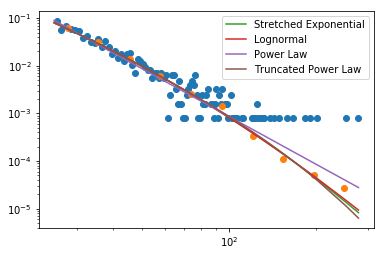

In [51]:
fit_Co = fit_power_law(Co_degree)

In [52]:
fit_Co.xmin

25.0

In [53]:
fit_Co.power_law.alpha

3.3514046617578286

In [54]:
compare_functions(fit_Co)

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


(                       exponential  stretched_exponential  lognormal  \
 exponential               0.000000             -47.632231 -47.476112   
 stretched_exponential    47.632231               0.000000   0.156119   
 lognormal                47.476112              -0.156119   0.000000   
 lognormal_positive       47.476112              -0.156119   0.000000   
 power_law                39.251731              -8.380500  -8.224381   
 truncated_power_law      47.684085               0.051854   0.207973   
 
                        lognormal_positive  power_law  truncated_power_law  
 exponential                    -47.476112 -39.251731           -47.684085  
 stretched_exponential            0.156119   8.380500            -0.051854  
 lognormal                        0.000000   8.224381            -0.207973  
 lognormal_positive               0.000000   8.224381            -0.207973  
 power_law                       -8.224381   0.000000            -8.432354  
 truncated_power_law     

In [55]:
p_value(fit_Co, sims=10)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


0.0

#### The Phonecalls Dataset

In [56]:
P = nx.DiGraph(name='phonecalls')
P.add_edges_from(phonecalls.values)
P_out_degree = [out_degree for (node, out_degree) in P.out_degree if out_degree > 0]
P_in_degree = [in_degree for (node, in_degree) in P.in_degree if in_degree > 0]
print(nx.info(P))

Name: phonecalls
Type: DiGraph
Number of nodes: 36595
Number of edges: 91826
Average in degree:   2.5092
Average out degree:   2.5092


Calculating best minimal value for power law fit


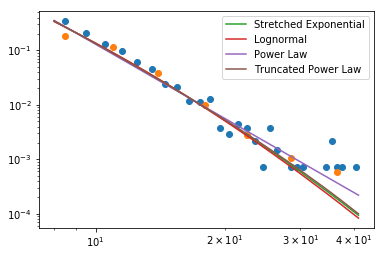

In [57]:
fit_P_out = fit_power_law(P_out_degree)

In [58]:
fit_P_out.xmin

8.0

In [59]:
fit_P_out.power_law.alpha

4.518884303185142

In [60]:
compare_functions(fit_P_out)

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


(                       exponential  stretched_exponential  lognormal  \
 exponential               0.000000             -28.440269 -28.570827   
 stretched_exponential    28.440269               0.000000  -0.130559   
 lognormal                28.570827               0.130559   0.000000   
 lognormal_positive       28.297338              -0.142931  -0.273490   
 power_law                25.410788              -3.029480  -3.160039   
 truncated_power_law      28.323093              -0.117176  -0.247735   
 
                        lognormal_positive  power_law  truncated_power_law  
 exponential                    -28.297338 -25.410788           -28.323093  
 stretched_exponential            0.142931   3.029480             0.117176  
 lognormal                        0.273490   3.160039             0.247735  
 lognormal_positive               0.000000   2.886549            -0.025755  
 power_law                       -2.886549   0.000000            -2.912304  
 truncated_power_law     

In [61]:
p_value(fit_P_out, sims=10)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


0.5

Calculating best minimal value for power law fit


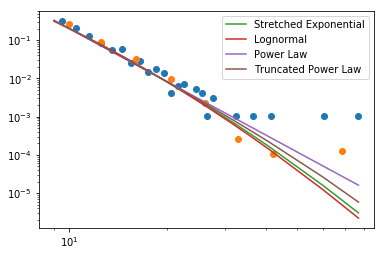

In [62]:
fit_P_in = fit_power_law(P_in_degree)

In [63]:
fit_P_in.xmin

9.0

In [64]:
fit_P_in.power_law.alpha

4.627294006680148

In [65]:
compare_functions(fit_P_in)

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


(                       exponential  stretched_exponential  lognormal  \
 exponential               0.000000             -27.907851 -28.286712   
 stretched_exponential    27.907851               0.000000  -0.378861   
 lognormal                28.286712               0.378861   0.000000   
 lognormal_positive       27.559749              -0.348101  -0.726962   
 power_law                27.249683              -0.658168  -1.037029   
 truncated_power_law      27.896924              -0.010927  -0.389788   
 
                        lognormal_positive  power_law  truncated_power_law  
 exponential                    -27.559749 -27.249683           -27.896924  
 stretched_exponential            0.348101   0.658168             0.010927  
 lognormal                        0.726962   1.037029             0.389788  
 lognormal_positive               0.000000   0.310067            -0.337174  
 power_law                       -0.310067   0.000000            -0.647241  
 truncated_power_law     

In [66]:
p_value(fit_P_in, sims=10)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


0.7

#### The Email Dataset

In [67]:
E = nx.DiGraph(name='email')
E.add_edges_from(email.values)
E_out_degree = [out_degree for (node, out_degree) in E.out_degree if out_degree > 0]
E_in_degree = [in_degree for (node, in_degree) in E.in_degree if in_degree > 0]
print(nx.info(E))

Name: email
Type: DiGraph
Number of nodes: 57194
Number of edges: 103731
Average in degree:   1.8137
Average out degree:   1.8137


Calculating best minimal value for power law fit


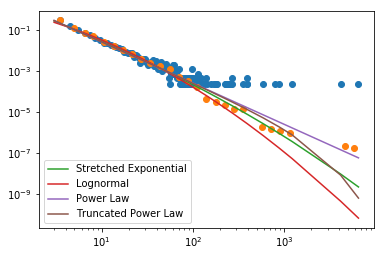

In [68]:
fit_E_out = fit_power_law(E_out_degree)

In [69]:
fit_E_out.xmin

3.0

In [70]:
fit_E_out.power_law.alpha

2.0060491661243693

In [71]:
compare_functions(fit_E_out)

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


(                       exponential  stretched_exponential    lognormal  \
 exponential               0.000000           -2742.131045 -2742.694073   
 stretched_exponential  2742.131045               0.000000    -0.563028   
 lognormal              2742.694073               0.563028     0.000000   
 lognormal_positive     2687.672331             -54.458714   -55.021742   
 power_law              2727.110148             -15.020896   -15.583924   
 truncated_power_law    2733.412533              -8.718512    -9.281540   
 
                        lognormal_positive    power_law  truncated_power_law  
 exponential                  -2687.672331 -2727.110148         -2733.412533  
 stretched_exponential           54.458714    15.020896             8.718512  
 lognormal                       55.021742    15.583924             9.281540  
 lognormal_positive               0.000000   -39.437818           -45.740202  
 power_law                       39.437818     0.000000            -6.302384  

In [72]:
p_value(fit_E_out, sims=10)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


0.2

Calculating best minimal value for power law fit


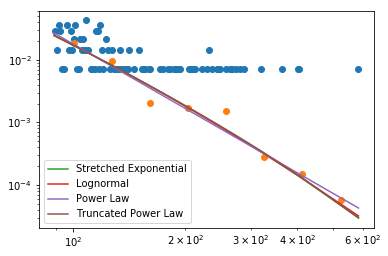

In [73]:
fit_E_in = fit_power_law(E_in_degree)

In [74]:
fit_E_in.xmin

89.0

In [75]:
fit_E_in.power_law.alpha

3.4273463456450557

In [76]:
compare_functions(fit_E_in)

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


(                       exponential  stretched_exponential  lognormal  \
 exponential               0.000000              -5.676341  -5.621521   
 stretched_exponential     5.676341               0.000000   0.054820   
 lognormal                 5.621521              -0.054820   0.000000   
 lognormal_positive        5.621521              -0.054820   0.000000   
 power_law                 5.167304              -0.509037  -0.454217   
 truncated_power_law       5.864931               0.188590   0.243411   
 
                        lognormal_positive  power_law  truncated_power_law  
 exponential                     -5.621521  -5.167304            -5.864931  
 stretched_exponential            0.054820   0.509037            -0.188590  
 lognormal                        0.000000   0.454217            -0.243411  
 lognormal_positive               0.000000   0.454217            -0.243411  
 power_law                       -0.454217   0.000000            -0.697627  
 truncated_power_law     

In [77]:
p_value(fit_E_in, sims=10)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


0.4

#### The WWW Dataset

In [78]:
W = nx.DiGraph(name='www')
W.add_edges_from(www.values) # takes a few minutes
W_out_degree = [out_degree for (node, out_degree) in W.out_degree if out_degree > 0]
W_in_degree = [in_degree for (node, in_degree) in W.in_degree if in_degree > 0]
print(nx.info(W))

Name: www
Type: DiGraph
Number of nodes: 325729
Number of edges: 1497134
Average in degree:   4.5963
Average out degree:   4.5963


Calculating best minimal value for power law fit


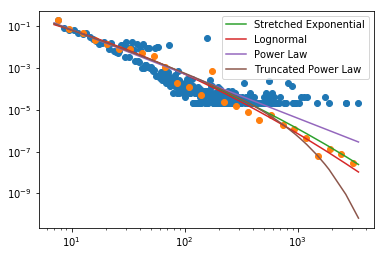

In [79]:
fit_W_out = fit_power_law(W_out_degree)

In [80]:
fit_W_out.xmin

7.0

In [81]:
fit_W_out.power_law.alpha

2.1219912040895665

In [82]:
compare_functions(fit_W_out)

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


(                        exponential  stretched_exponential     lognormal  \
 exponential                0.000000          -14188.466095 -14173.879104   
 stretched_exponential  14188.466095               0.000000     14.586991   
 lognormal              14173.879104             -14.586991      0.000000   
 lognormal_positive     13952.134694            -236.331401   -221.744410   
 power_law              13998.121628            -190.344467   -175.757476   
 truncated_power_law    14325.547092             137.080996    151.667988   
 
                        lognormal_positive     power_law  truncated_power_law  
 exponential                 -13952.134694 -13998.121628        -14325.547092  
 stretched_exponential          236.331401    190.344467          -137.080996  
 lognormal                      221.744410    175.757476          -151.667988  
 lognormal_positive               0.000000    -45.986934          -373.412398  
 power_law                       45.986934      0.000000   

In [83]:
p_value(fit_W_out, sims=10)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


0.0

Calculating best minimal value for power law fit


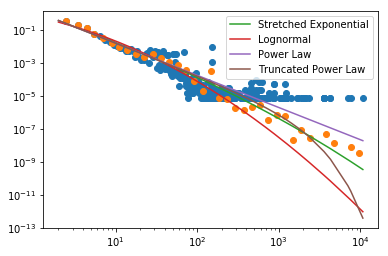

In [84]:
fit_W_in = fit_power_law(W_in_degree)

In [85]:
fit_W_in.xmin

2.0

In [86]:
fit_W_in.power_law.alpha

1.9507535028318905

In [87]:
compare_functions(fit_W_in)

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


(                        exponential  stretched_exponential     lognormal  \
 exponential                0.000000          -85334.957329 -85564.314416   
 stretched_exponential  85334.957329               0.000000   -229.357087   
 lognormal              85564.314416             229.357087      0.000000   
 lognormal_positive     81496.085295           -3838.872035  -4068.229122   
 power_law              85410.262450              75.305120   -154.051967   
 truncated_power_law    85720.253294             385.295965    155.938878   
 
                        lognormal_positive     power_law  truncated_power_law  
 exponential                 -81496.085295 -85410.262450        -85720.253294  
 stretched_exponential         3838.872035    -75.305120          -385.295965  
 lognormal                     4068.229122    154.051967          -155.938878  
 lognormal_positive               0.000000  -3914.177155         -4224.167999  
 power_law                     3914.177155      0.000000   

In [88]:
p_value(fit_W_in, sims=10)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


0.0

#### The Citation Dataset

In [89]:
Ci = nx.DiGraph(name='citation')
Ci.add_edges_from(citation.values) # takes a few minutes
Ci_out_degree = [out_degree for (node, out_degree) in Ci.out_degree if out_degree > 0]
Ci_in_degree = [in_degree for (node, in_degree) in Ci.in_degree if in_degree > 0]
print(nx.info(Ci))

Name: citation
Type: DiGraph
Number of nodes: 449673
Number of edges: 4689479
Average in degree:  10.4286
Average out degree:  10.4286


Calculating best minimal value for power law fit


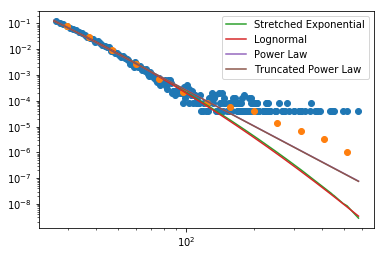

In [90]:
fit_Ci_out = fit_power_law(Ci_out_degree)

In [91]:
fit_Ci_out.xmin

26.0

In [92]:
fit_Ci_out.power_law.alpha

4.617645418296465

In [93]:
compare_functions(fit_Ci_out)

Assuming nested distributions
Assuming nested distributions
C:\Anaconda3\lib\site-packages\powerlaw.py:1560: RuntimeWarning: invalid value encountered in true_divide
  return likelihoods/norm
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


(                       exponential  stretched_exponential    lognormal  \
 exponential               0.000000           -1785.967239 -1888.776968   
 stretched_exponential  1785.967239               0.000000  -102.809729   
 lognormal              1888.776968             102.809729     0.000000   
 lognormal_positive     1781.704558              -4.262682  -107.072410   
 power_law              1884.189937              98.222698    -4.587031   
 truncated_power_law    1884.234438              98.267199    -4.542530   
 
                        lognormal_positive    power_law  truncated_power_law  
 exponential                  -1781.704558 -1884.189937         -1884.234438  
 stretched_exponential            4.262682   -98.222698           -98.267199  
 lognormal                      107.072410     4.587031             4.542530  
 lognormal_positive               0.000000  -102.485380          -102.529880  
 power_law                      102.485380     0.000000            -0.044501  

In [94]:
p_value(fit_Ci_out, sims=10)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


0.0

Calculating best minimal value for power law fit


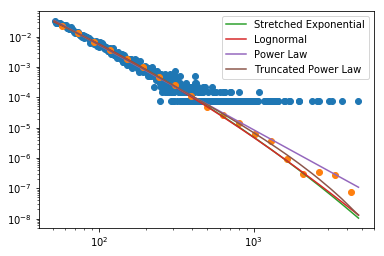

In [95]:
fit_Ci_in = fit_power_law(Ci_in_degree)

In [96]:
fit_Ci_in.xmin

51.0

In [97]:
fit_Ci_in.power_law.alpha

2.7944492633659723

In [98]:
compare_functions(fit_Ci_in)

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


(                       exponential  stretched_exponential    lognormal  \
 exponential               0.000000           -2131.962901 -2143.855513   
 stretched_exponential  2131.962901               0.000000   -11.892613   
 lognormal              2143.855513              11.892613     0.000000   
 lognormal_positive     2131.804239              -0.158661   -12.051274   
 power_law              2127.167628              -4.795273   -16.687885   
 truncated_power_law    2141.614330               9.651429    -2.241183   
 
                        lognormal_positive    power_law  truncated_power_law  
 exponential                  -2131.804239 -2127.167628         -2141.614330  
 stretched_exponential            0.158661     4.795273            -9.651429  
 lognormal                       12.051274    16.687885             2.241183  
 lognormal_positive               0.000000     4.636611            -9.810091  
 power_law                       -4.636611     0.000000           -14.446702  

In [99]:
fit_Ci_in.truncated_power_law.alpha

2.6830956760014693

In [100]:
p_value(fit_Ci_in, sims=10)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


0.0

#### The Actor Dataset

In [101]:
A = nx.Graph(name='actor')
A.add_edges_from(actor.values) # takes a few minutes
A_degree = [degree for (node, degree) in A.degree]
print(nx.info(A))

Name: actor
Type: Graph
Number of nodes: 702388
Number of edges: 29397908
Average degree:  83.7085


Calculating best minimal value for power law fit


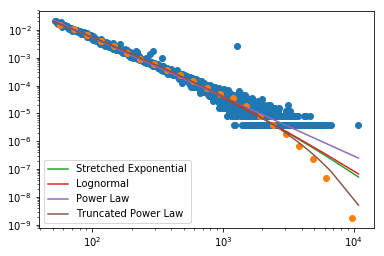

In [102]:
fit_A = fit_power_law(A_degree)

In [103]:
fit_A.xmin

51.0

In [104]:
fit_A.power_law.alpha

2.120291313530346

In [105]:
compare_functions(fit_A)

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


(                        exponential  stretched_exponential     lognormal  \
 exponential                0.000000          -68143.046091 -68020.297539   
 stretched_exponential  68143.046091               0.000000    122.748551   
 lognormal              68020.297539            -122.748551      0.000000   
 lognormal_positive     68015.108077            -127.938014     -5.189463   
 power_law              66458.960135           -1684.085956  -1561.337405   
 truncated_power_law    68675.156924             532.110834    654.859385   
 
                        lognormal_positive     power_law  truncated_power_law  
 exponential                 -68015.108077 -66458.960135        -68675.156924  
 stretched_exponential          127.938014   1684.085956          -532.110834  
 lognormal                        5.189463   1561.337405          -654.859385  
 lognormal_positive               0.000000   1556.147942          -660.048848  
 power_law                    -1556.147942      0.000000   

In [106]:
fit_A.truncated_power_law.alpha

1.933681851056846

In [107]:
p_value(fit_A, sims=10)

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


0.0